# TABLE OF CONTENTS:
---
* [Workspace](#Workspace)
* [Data](#Data)
* [Compute Target](#Compute-Target)
* [Training Artifacts](#Training-Artifacts)
* [Development Environment](#Development-Environment)
* [Compute Target](#Compute-Target)
* [Development Environment](#Development-Environment)
* [Experiment & Run Configuration](#Experiment-&-Run-Configuration)
* [Model Registration](#Model-Registration)
* [Resource Clean Up](#Resource-Clean-Up)
---

In [1]:
import sys

# Append parent directory to sys path to be able to import from src directory
sys.path.append(os.path.dirname(os.path.abspath("")))

In [2]:
import azureml.core
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import scipy.io
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from azureml.core import Dataset, Environment, Experiment, Keyvault, Model, ScriptRunConfig, Workspace
from azureml.core.compute import AmlCompute, ComputeTarget
from azureml.core.compute_target import ComputeTargetException
from azureml.core.model import InferenceConfig 
from azureml.widgets import RunDetails
from torchvision import datasets

from src.training.data_utils import load_data, show_image
from src.training.download_utils import download_file, extract_stanford_dogs_archive

print(f"azureml.core version: {azureml.core.VERSION}")

azureml.core version: 1.19.0


In [3]:
# Automatically reload modules when changes are made
%load_ext autoreload
%autoreload 2

Create a training directory. This directory will contain all artifacts needed for model training. For AML remote training this directory will be copied to the remote compute at runtime.

In [ ]:
training_folder = os.path.join(os.getcwd(), "../src/training")
os.makedirs(training_folder, exist_ok=True)
print(f"Training folder {training_folder} has been created.")

# Workspace

In order to connect and communicate with the Azure Machine Learning (AML) workspace, a workspace object needs to be instantiated using the azureml SDK.

### Option 1: Create Workspace Object from Config

This option requires a config.json file containing the subscription id, resource group and workspace name. On an AML Compute Instance, this is available by default. For any other compute, the file can be downloaded from the workspace and put in the same directory as the calling file, a subdirectory named .azureml, or in a parent directory. Alternatively, the path can also be manually specified using the `path` argument.

<img src="../images/config_file.png" alt="config_file" width="600"/>

In [4]:
ws = Workspace.from_config() 
print("Workspace name: " + ws.name, 
      "Azure region: " + ws.location, 
      "Subscription id: " + ws.subscription_id, 
      "Resource group: " + ws.resource_group, sep="\n")

# Retrieve workspace details
# ws.get_details()

Workspace name: amlbriksews
Azure region: westeurope
Subscription id: bf088f59-f015-4332-bd36-54b988be7c90
Resource group: amlbrikserg


### Option 2: Create Workspace from Connection Info

In [55]:
# ws = Workspace.get(name="amlbriksews",
#                    subscription_id="bf088f59-f015-4332-bd36-54b988be7c90",
#                    resource_group="amlbrikserg") 

# # Retrieve workspace details
# # ws.get_details()

# Data

In order to train the model, the [stanford dogs image dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) is used for multiclass classification. It has the classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. The images in CIFAR-10 are three-channel color images of 32x32 pixels in size.

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

[dataset](http://www.cs.toronto.edu/~kriz/cifar.html)

### Download Data

Create a utility file for functions to download the dogs dataset from the stanford vision website and extract images.

In [7]:
%%writefile $training_folder/download_utils.py
import os
import scipy.io
import shutil
import urllib
import tarfile
import tqdm


def download_file(download_url: str,
                  file_dir_path: str,
                  file_name: str,
                  skip_if_dir_exists: bool = False,
                  force_dir_deletion: bool = False) -> None:
    """
    Download a file
    :param download_url: url from where to download
    :param file_dir_path: directory to which to download
    :param file_name: name of the file
    :param skip_if_dir_exists: flag that indicates whether to skip the download if the directory already exists
    :param force_dir_deletion: flag that indicates whether to delete the existing directory before the download
    """
    
    # Remove file directory if it exists
    if force_dir_deletion:
        shutil.rmtree(file_dir_path)
    
    # Check if download should be triggered
    if not os.path.exists(file_dir_path) or not skip_if_dir_exists:
    
        # Create file directory if it does not exist
        os.makedirs(file_dir_path, exist_ok=True)
    
        # Download the file
        file_path = os.path.join(file_dir_path, file_name)
        print("Downloading " + download_url + " to " + file_path)
        urllib.request.urlretrieve(download_url, filename=file_path, reporthook=generate_bar_updater())
        

def extract_stanford_dogs_archive(archive_dir_path: str = "../data",
                                  target_dir_path: str = "../data",
                                  remove_archives: bool = True) -> None:
    """
    Extract the stanford dogs image archive and separate the images into training,
    validation and test set
    :param archive_dir_path: path of the "image.tar" and "lists.tar" files to be extracted
    :param target_dir_path: path of the target directory where the file should be extracted to
    :param remove_archives: flag that indicates whether the archives are removed after extraction
    """
 
    # Specify directory paths
    training_dir = os.path.join(target_dir_path, "train")
    validation_dir = os.path.join(target_dir_path, "val")
    test_dir = os.path.join(target_dir_path, "test")                            

    # Extract lists.tar archive
    with tarfile.open(os.path.join(archive_dir_path, "lists.tar"), "r") as lists_tar:
        lists_tar.extractall(path=archive_dir_path)
                             
    print("Lists.tar archive has been extracted successfully.")
    
    # Load list.mat files
    train_list_mat = scipy.io.loadmat(os.path.join(archive_dir_path, "train_list.mat"))
    test_list_mat = scipy.io.loadmat(os.path.join(archive_dir_path, "test_list.mat"))
    
    training_files = []
    test_and_val_files = []
    
    # Extract training data file names
    for array in train_list_mat["file_list"]:
        training_files.append(array[0][0])

    # Extract test data file names
    for array in test_list_mat["file_list"]:
        test_and_val_files.append(array[0][0])
                             
    print("File lists have been read successfully.")
    print("Extracting images.tar archive...")
                             
    # Extract images.tar archive
    with tarfile.open(os.path.join(archive_dir_path, "images.tar"), "r") as images_tar:
        test_val_idx = 0
        for member in tqdm.tqdm(images_tar.getmembers()):
            if member.isreg(): # Skip if TarInfo is not files
                member.name = member.name.split("/", 1)[1] # Retrieve only relevant part of file name
                
                # Extract files to corresponding directories
                if member.name in training_files:
                    images_tar.extract(member, training_dir)
                    
                elif member.name in test_and_val_files: # Every 2nd file goes to the validation data
                    test_val_idx+=1
                    if test_val_idx % 2 != 0:
                        images_tar.extract(member, validation_dir)
                    else:
                        images_tar.extract(member, test_dir)
                             
    print("Images.tar archive has been extracted successfully.")

    # Remove list.mat files
    os.remove(os.path.join(archive_dir_path, "file_list.mat"))
    os.remove(os.path.join(archive_dir_path, "test_list.mat"))
    os.remove(os.path.join(archive_dir_path, "train_list.mat"))
    
    # Remove archive files if flag is set to true
    if remove_archives:
        print("Removing archive files.")
        os.remove(os.path.join(archive_dir_path, "lists.tar"))
        os.remove(os.path.join(archive_dir_path, "images.tar"))

                             
def generate_bar_updater():
    """
    Create a tqdm reporthook function for urlretrieve
    :returns: bar_update function which can be used by urlretrieve 
              to display and update a progress bar
    """
    
    pbar = tqdm.tqdm(total=None)

    # Define progress bar update function
    def bar_update(count, block_size, total_size):
        if pbar.total is None and total_size:
            pbar.total = total_size
        progress_bytes = count * block_size
        pbar.update(progress_bytes - pbar.n)

    return bar_update

Overwriting ../src/training/download_utils.py


In [8]:
archive_file_list = ["images.tar", "lists.tar"]

# Download archive files from the stanford vision website
for archive_file in archive_file_list:
    download_file(download_url="http://vision.stanford.edu/aditya86/ImageNetDogs/" + archive_file,
                  file_dir_path="../data",
                  file_name=archive_file,
                  skip_if_dir_exists=False,
                  force_dir_deletion=False)

0it [00:00, ?it/s]

 42%|████▏     | 334741504/793579520 [00:23<00:23, 19155051.11it/s]

KeyboardInterrupt: 

In [ ]:
# Extract archive files
extract_stanford_dogs_archive()

 43%|████▎     | 337707008/793579520 [00:40<00:23, 19155051.11it/s]

In [ ]:
data_dir = "../data"

In [44]:
%%writefile $training_folder/data_utils.py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import torch
import torchvision.transforms as transforms

from torchvision import datasets
from typing import Tuple

def load_data(data_dir: str) -> Tuple[dict, dict, list]:
    """
    Load the train, val and test data.
    :param data_dir: path where the images are stored
    :return (image_dataloaders, dataset_sizes, class_names)
        dataloaders: dictionary of train, val, and test Pytorch dataloaders
        dataset_sizes: dictionary of train, val and test Pytorch dataset lengths
        class_names: list of all classes
    """

    # Data augmentation and normalization for training set
    # Just normalization for validation and test set
    data_transforms = {
        "train": transforms.Compose([
            transforms.RandomResizedCrop(224, scale=(0.5, 1)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
        "val": transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
        "test": transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
    }
    
    # Dictionary of image datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ["train", "val", "test"]}
    
    # Dictionary of image dataloaders
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                        shuffle=True, num_workers=2) 
                         for x in ["train", "val", "test"]}
    
    # Dictionary of dataset sizes
    dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val", "test"]}
    
    # List of class names
    class_names = image_datasets["train"].classes
    
    return dataloaders, dataset_sizes, class_names


def show_image(image_path: str) -> None:
    """
    Load and show an example image
    :param image_path: path of the image to be loaded
    """
    # Read in example image
    img = mpimg.imread(image_path)

    # Check format of image
    print(f"Image shape: {img.shape}")

    # Show example image
    imgplot = plt.imshow(img)

Overwriting ../src/training/data_utils.py


Use the Pytorch dataset and dataloader classes to download the CIFAR-10 data to the AML Compute Instance / local compute.

### Explore Data

Display an example image. All images have different shapes.

Image shape: (375, 500, 3)


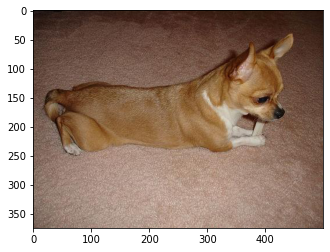

In [9]:
show_image(image_path="../data/train/n02085620-Chihuahua/n02085620_11140.jpg")

Display the first batch of 4 images.

In [10]:
dataloaders, dataset_sizes, class_names = load_data("../data")

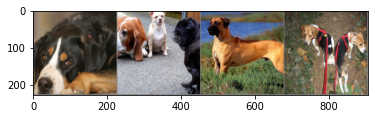

Greater_Swiss_Mountain_dog
basset
Great_Dane
beagle


In [13]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # transpose dimensions from Pytorch format to default numpy format
    plt.show()

# Get some random training images
dataiter = iter(dataloaders["train"])
images, labels = dataiter.next()

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print("\n".join("%s" % class_names[labels[j]].split('-')[1] for j in range(4)))

Check number of classes.

In [20]:
print(f"Number of classes: {len(class_names)}")

Number of classes: 120


### Upload Data

Upload the data to the default AML datastore.

In [19]:
datastore = ws.get_default_datastore()
datastore.upload(src_dir="../data", target_path="data/stanford_dogs", overwrite=True, show_progress=False)

$AZUREML_DATAREFERENCE_dc17cc63434648e0ad0c4b29d50dea29

### Create and Register AML Datasets

In [40]:
# Create dataset object from datastore location
dataset = Dataset.File.from_files(path=(datastore, "data/stanford_dogs"))

In [41]:
# Register the dataset
dataset = train_dataset.register(workspace=ws,
                                 name="stanford_dogs",
                                 description="Stanford dogs dataset",
                                 create_new_version=True)

# Compute Target

Create a remote compute target to run the experiment on. The below code will first check whether a compute target with name `cpu_cluster_name` already exists and if it does it will use that.

In [ ]:
# Choose a name for the CPU cluster
cluster_name = "cpu-cluster"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print("Found existing cluster, use it.")
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size="STANDARD_D2_V2", # CPU
                                                           # vm_size='STANDARD_NC6', # GPU
                                                           max_nodes=4,
                                                           idle_seconds_before_scaledown=2400)
    
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

# Use get_status() to get a detailed status for the current cluster
print(compute_target.get_status().serialize())

# Training Artifacts

Create a training script in the training directory. The training script will make use of transfer learning and use a pretrained Resnet18 model. The final fully connected layer of this model will be adjusted for multiclass classification with 120 target classes. All parameters of the model will then be trained on the stanford dogs dataset.

In [57]:
%%writefile $training_folder/train.py
import argparse
import copy
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import urllib

from azureml.core import Run
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from zipfile import ZipFile

from data_utils import load_data
from model import Net

run = Run.get_context()


def train_model(model: torchvision.models,
                criterion: torch.nn.modules.loss,
                optimizer: torch.optim,
                scheduler: torch.optim.lr_scheduler,
                num_epochs: int,
                dataloaders: dict,
                dataset_sizes: dict) -> torchvision.models:
    """
    Train the model on the stanford dogs dataset and track training
    and validation loss and accuracy.
    :param model: pretrained model which will be trained further
    :param criterion: torch loss function
    :param optimizer: torch optimizer
    :param scheduler: torch learning rate scheduler
    :param num_epochs: number of epochs to train the model
    :param dataloaders: dictionary of torch dataloaders
    :param dataset_sizes: dictionary with lengths of the training, val and test set
    :return model: pretrained model with tuned final fully connected layer
    """
    
    # Leverage GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    start_time = time.time()

    # Load in weights of model
    best_model_weights = copy.deepcopy(model.state_dict())
    
    best_acc = 0.0

    for epoch in range(num_epochs):
        print("-" * 20)
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 20)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluate mode

            running_loss = 0.0
            running_correct_preds = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                # Track history only if in training phase
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and gradient optimization only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Calculate statistics
                running_loss += loss.item() * inputs.size(0)
                running_correct_preds += torch.sum(preds == labels.data)
                
            # Update learning rate if in training phase
            if phase == "train":
                scheduler.step() 

            # Average loss and accuracy over examples
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_correct_predictions.double() / dataset_sizes[phase]

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())

            # Log the best val accuracy to AML run
            run.log("best_val_acc", np.float(best_acc))
            print("-" * 20)

    time_elapsed = time.time() - start_time
    
    print(f"Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s.")
    print(f"Best Val Acc: {best_acc:4f}")
          
    # Load best model weights
    model.load_state_dict(best_model_weights)
          
    return model


def fine_tune_model(num_epochs: int,
                    num_classes: int,
                    dataloaders: dict,
                    dataset_sizes: dict,
                    learning_rate: float,
                    momentum: float) -> torchvision.models:
    """
    Load a pretrained model and reset the final fully connected layer.
    :param num_epochs: number of epochs to train the model
    :param num_classes: number of target classes 
        (supports binary and multiclass classification)
    :param dataloaders: dictionary of torch dataloaders
    :param dataset_sizes: dictionary with lengths of the training, val and test set
    :param learning_rate: learning rate hyperparameter
    :param momentum: momentum hyperparameter
    :return model: pretrained model with tuned final fully connected layer
    """

    print("-" * 20)
    print("START TRAINING")
    print("-" * 20)
    
    # Log the hyperparameter metrics to the AML run
    run.log("lr", np.float(learning_rate))
    run.log("momentum", np.float(momentum))

    # Load pretrained model and reset final fully connected layer to have num_classes output neurons
    model_ft = models.resnet18(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)

    # Leverage GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model_ft = model_ft.to(device)

    # Specify loss function
    criterion = nn.CrossEntropyLoss()

    # Create SGD optimizer to optimize all parameters
    optimizer_ft = optim.SGD(model_ft.parameters(),
                             lr=learning_rate,
                             momentum=momentum)
                            
    # Create scheduler to decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft,
                                           step_size=7,
                                           gamma=0.1)
    
    # Start model training
    model = train_model(model_ft, criterion, optimizer_ft,
                        exp_lr_scheduler, num_epochs, dataloaders,
                        dataset_sizes)

    return model


def main():
    
    print("Torch version:", torch.__version__)
    
    # Retrieve command-line arguments
    parser = argparse.ArgumentParser()
    parser.add_argument("--data_path", type=str, help="Path where the images are stored")
    parser.add_argument("--num_epochs", type=int, default=25, help="Number of epochs to train")
    parser.add_argument("--output_dir", type=str, help="Output directory")
    parser.add_argument("--learning_rate", type=float, default=0.001, help="Learning rate")
    parser.add_argument("--momentum", type=float, default=0.9, help="Momentum")
    args = parser.parse_args()
         
    print("-" * 20)
    print("LOAD DATA")      
    print("-" * 20)
          
    # Load training and validation data
    dataloaders, dataset_sizes, class_names = load_data(args.data_path)
          
    print("Data has been load successfully.")
        
    # Train the model
    model = fine_tune_model(num_epochs=args.num_epochs,
                            num_classes=len(class_names),
                            dataloaders=dataloaders,
                            dataset_sizes=dataset_sizes,
                            learning_rate=args.learning_rate,
                            momentum=args.momentum)
    
    # Save the model
    os.makedirs(args.output_dir, exist_ok=True)
    torch.save(model, os.path.join(args.output_dir, "model.pt"))
    print(f"Model saved in {args.output_dir}.")


if __name__ == "__main__":
    main()

Overwriting /mnt/batch/tasks/shared/LS_root/mounts/clusters/amlbriksevnetci/code/Users/BRIKSE/pytorch-use-cases-azure-ml/template_project/notebooks/../src/training/train.py


Alternatively to transfer learning, create a model file which contains the network architecture of a new model.

In [58]:
%%writefile $training_folder/model.py
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Overwriting /mnt/batch/tasks/shared/LS_root/mounts/clusters/amlbriksevnetci/code/Users/BRIKSE/pytorch-use-cases-azure-ml/template_project/notebooks/../src/training/model.py


Run the training script locally for 1 epoch for debugging purposes.

In [ ]:
!python ../src/training/train.py --data_path "../data" --num_epochs 1 --output_dir "../outputs" --learning_rate 0.003 --momentum 0.9

Torch version: 1.6.0
--------------------
LOAD DATA
--------------------
Data has been load successfully.
--------------------
START TRAINING
--------------------
Attempted to log scalar metric lr:
0.003
Attempted to log scalar metric momentum:
0.9
--------------------
Epoch 1/1
--------------------


# Development Environment

Create an **environment.yml** file which contains all packages needed for development, training and deployment.

In [ ]:
%%writefile ../environments/conda/environment.yml

name: pytorch-aml-env
dependencies:
- python=3.7.1
- pytorch::pytorch=1.7.0
- pytorch::torchvision=0.8.1
- pip:
    - azureml-defaults
    - azureml-sdk
    - azureml-widgets
channels:
- pytorch

A yml file with conda environment specification is provided in `../environments/conda`. By instantiating an environment object, this conda environment can be used for the remote training run. Alternatively, AML curated environments can also be used. AML curated environments cover common ML scenarios and are backed by cached Docker images. Cached Docker images make the first remote run preparation faster.

In [ ]:
# # Display AML Curated Environments
# envs = Environment.list(workspace=ws)

# for env in envs:
#     if env.startswith("AzureML"):
#         print("Name", env)
#         print("packages", envs[env].python.conda_dependencies.serialize_to_string())

In [ ]:
# # List workspace environments
# for name, env in ws.environments.items():
#     print(f"Name {name} \t version {env.version}")

# # Retrieve an environment
# env = Environment.get(workspace=ws, name="AzureML-PyTorch-1.3-CPU", version="1")

# # Get base image of retrieved environment
# print(env.docker.base_image)

# print("\n Attributes of retrieved environment:")
# env

On the first run in a given environment, Azure ML spends some time building the environment. On the subsequent runs, Azure ML keeps track of changes and uses the existing environment, resulting in faster run completion.

In [ ]:
env = Environment.from_conda_specification(name="pytorch-aml-env",
                                           file_path="../environments/conda/environment.yml")

# Attribute docker.enabled controls whether to use Docker container or host OS for execution.
# This is only relevant for local execution as execution on AML Compute Cluster will always use Docker container.
# env.docker.enabled = True

# Use Python dependencies from your Docker image (as opposed to from conda specification)
# env.python.user_managed_dependencies=True

## Only uncomment one of the three below options
# OPTION 1: Use mcr base image
#env.docker.base_image = "mcr.microsoft.com/azureml/intelmpi2018.3-ubuntu16.04:20201113.v1"
#env.docker.base_image = 'mcr.microsoft.com/azureml/openmpi3.1.2-cuda10.1-cudnn7-ubuntu18.04' # GPU base image

# Option 2: Use custom base image from workspace-native ACR
#env.docker.base_image = "eafc0c3ef9714c74a4fa655ee90531ba.azurecr.io/base/pytorch"

# OPTION 3: Use custom base image from standalone ACR and use admin user credentials. For this you need to enable admin user in the ACR.
env.docker.base_image = "sbirkacr.azurecr.io/base/pytorch"
env.docker.base_image_registry.address = "sbirkacr.azurecr.io"
env.docker.base_image_registry.username = "sbirkacr"
env.docker.base_image_registry.password = "HqAu5Y2We0gZ42IunR5MBXkKc+shf2uj" # replace with Key Vault

# Option 4: Use custom base image from standalone ACR and use service principal authentication. 
#           The service principal needs the AcrPull permission on the standalone ACR.
env.docker.base_image = "sbirkacr.azurecr.io/base/pytorch"
env.docker.base_image_registry.address = "sbirkacr.azurecr.io"
env.docker.base_image_registry.username = keyvault.get_secret(name="sbirk-acr-sp-username")
env.docker.base_image_registry.password = keyvault.get_secret(name="sbirk-acr-sp-password")

# Option 5: Use custom base image from standalone ACR with anonymous access preview feature.
# env.docker.base_image = "sbirkacr.azurecr.io/base/pytorch"

# Create an environment variable.
# This can be retrieved in the training script with os.environ.get("MESSAGE").
# env.environment_variables = {"MESSAGE": "Hello from Azure Machine Learning"}

env.register(workspace=ws)

# Experiment & Run Configuration

Now that the training artifacts are prepared, a model can be trained on the remote compute cluster. You can take advantage of Azure compute to leverage GPUs to cut down your training time. 

### Option 1: "Normal" Script Run

In [ ]:
# Create the experiment
experiment = Experiment(workspace=ws, 
                        name="cifar-image-classification-pytorch")

# Create the script run configuration
config = ScriptRunConfig(source_directory="../src/training",
                         script="train.py",
                         compute_target=cpu_cluster_name,
                         arguments=[
                             "--data_path", dataset.as_named_input("input").as_mount(),
                             "--num_epochs", 25,
                             "--output_dir", "./outputs"
                             "--learning_rate", 0.001,
                             "--momentum", 0.9])

config.run_config.environment = env

# Submit the run
run = experiment.submit(config)
RunDetails(run).show()

In [ ]:
    parser.add_argument("--data_path", type=str, help="Path to the training data")
    parser.add_argument("--num_epochs", type=int, default=25, help="number of epochs to train")
    parser.add_argument("--output_dir", type=str, help="output directory")
    parser.add_argument("--learning_rate", type=float, default=0.001, help="learning rate")
    parser.add_argument("--momentum", type=float, default=0.9, help="momentum")

### Option 2: Hyperdrive Run

In [ ]:
# Get portal URL
run.get_portal_url()

In [ ]:
run.wait_for_completion(show_output=False)

In [ ]:
# Check run metrics, details and file names
print(run.get_metrics())
print(run.get_details())
print(run.get_file_names())

# Model Registration

In [ ]:
model_path = "outputs/cifar_net.pt"

model = run.register_model(model_name="cifar10-model",
                           model_path=model_path,
                           model_framework=Model.Framework.PYTORCH,
                           description="cifar10 model")

print(model.name, model.id, model.version, sep="\t")

In [ ]:
# Download the model
run.download_file(name=os.path.join("../", model_path))

# Resource Clean Up

In [ ]:
# cpu_cluster.delete()

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/NotebookVM/tutorials/get-started-day1/day1-part4-data.png)

In [ ]:
from azureml.core.authentication import InteractiveLoginAuthentication
interactive_auth = InteractiveLoginAuthentication(tenant_id="your-tenant-id")
Additional details on authentication can be found here: https://aka.ms/aml-notebook-auth 

> <span style="color:purple; font-weight:bold">! NOTE <br>
> The very first run will take 5-10minutes to complete. This is because in the background a docker image is built in the cloud, the compute cluster is resized from 0 to 1 node, and the docker image is downloaded to the compute. Subsequent runs are much quicker (~15 seconds) as the docker image is cached on the compute - you can test this by resubmitting the code below after the first run has completed.</span>

> <span style="color:purple; font-weight:bold">! NOTE <br>
> The first time you run this script, Azure Machine Learning will build a new docker image from your PyTorch environment. The whole run could take 5-10 minutes to complete. You can see the docker build logs in the widget by selecting the `20_image_build_log.txt` in the log files dropdown. This image will be reused in future runs making them run much quicker.</span>

## Monitor a remote run

In total, the first run takes **approximately 10 minutes**. But for subsequent runs, as long as the dependencies in the Azure ML environment don't change, the same image is reused and hence the container start up time is much faster.

Here is what's happening while you wait:

- **Image creation**: A Docker image is created matching the Python environment specified by the Azure ML environment. The image is built and stored in the ACR (Azure Container Registry) associated with your workspace. Image creation and uploading takes **about 5 minutes**. 

  This stage happens once for each Python environment since the container is cached for subsequent runs.  During image creation, logs are streamed to the run history. You can monitor the image creation progress using these logs.

- **Scaling**: If the remote cluster requires more nodes to execute the run than currently available, additional nodes are added automatically. Scaling typically takes **about 5 minutes.**

- **Running**: In this stage, the necessary scripts and files are sent to the compute target, then data stores are mounted/copied, then the entry_script is run. While the job is running, stdout and the files in the ./logs directory are streamed to the run history. You can monitor the run's progress using these logs.

- **Post-Processing**: The ./outputs directory of the run is copied over to the run history in your workspace so you can access these results.

To run this notebook you will need to create an Azure Machine Learning _compute instance_. The benefits of a compute instance over a local machine (e.g. laptop) or cloud VM are as follows:

* It is a pre-configured with all the latest data science libaries (e.g. panads, scikit, TensorFlow, PyTorch) and tools (Jupyter, RStudio). In this tutorial we make extensive use of PyTorch, AzureML SDK, matplotlib and we do not need to install these components on a compute instance.
* Notebooks are seperate from the compute instance - this means that you can develop your notebook on a small VM size, and then seamlessly scale up (and/or use a GPU-enabled) the machine when needed to train a model.
* You can easily turn on/off the instance to control costs. 